In [1]:
import hydrofunctions as hf
import pandas as pd
import numpy as np
from zipfile import ZipFile
import os
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style("ticks")
import random

In [2]:
river='Niagara_R'

location = (43.011981, -78.972581)

In [53]:
usgs_stations = pd.read_csv(ZipFile('../../measurements/USGS stream data/NEW YORK stations.zip').open(name='station.csv'))
usgs_samples = pd.read_csv(ZipFile('../../measurements/USGS stream data/NEW YORK samples.zip').open(name='result.csv'))
    
near_usgs_stations = usgs_stations[(usgs_stations.LatitudeMeasure>location[0]-delta) & (usgs_stations.LatitudeMeasure<location[0]+delta) &
                     (usgs_stations.LongitudeMeasure>location[1]-delta) & (usgs_stations.LongitudeMeasure<location[1]+delta)]


csv_file_df = usgs_samples[usgs_samples.MonitoringLocationIdentifier.isin(near_usgs_stations.MonitoringLocationIdentifier.unique())]
csv_file_df['ActivityStartDate'] = pd.to_datetime(csv_file_df['ActivityStartDate'], errors='coerce')
# database = csv_file_df.ProviderName.unique()[0]
# csv_file_df['']
df = pd.DataFrame(columns=['Date', 'MonitoringLocationIdentifier'])
df = csv_file_df
df = csv_file_df[(csv_file_df['CharacteristicName']=="Chloride")  & (csv_file_df['ActivityStartDate'].dt.year>1995)]
df.shape              

near_usgs_stations = near_usgs_stations.rename(index=str, columns={'MonitoringLocationIdentifier':'STATION', 'LatitudeMeasure':'Latitude'.upper(), 'LongitudeMeasure':'Longitude'.upper()})
near_usgs_stations = near_usgs_stations[['STATION', 'LONGITUDE', 'LATITUDE']]


In [78]:
WSC_STATIONS = pd.read_pickle('../Loadings Canada 2/data/WSC_STATIONS')
WSC_FLOWS = pd.read_pickle('../Loadings Canada 2/data/WSC_FLOWS')
WSC_STATIONS = WSC_STATIONS[WSC_STATIONS.Flow == True]

PWQMN = pd.read_pickle('../Loadings Canada 2/data/PWQMN')

elem = 'CHLORIDE,         UNFIL.REAC'
PWQMN = PWQMN[(PWQMN["PARM DESCRIPTION"]==elem) & (PWQMN.UNITS!='FORMAZIN TURBIDITY UNIT')]
# PWQMN.loc[PWQMN.UNITS=='MICROGRAM PER LITER', "RESULT"] = PWQMN.RESULT/1000


PWQMN_LOC = pd.read_excel('../../measurements/PWQMN/PWQMN Locations.xlsx')

GLNI = pd.read_excel('../../measurements/GLNI/Canadian_Tributaries_concentrations_Serghei.xlsx', sheet_name='Data_GLNI_Erie tribs')

elem_name='Chloride'

GLNI = GLNI[GLNI.VariableCommonName==elem_name]

GLNI.SiteName.unique()

delta = 0.5

niagara_nurients = pd.read_excel('../../measurements/ECCC/Niagara River/Copy of Nutrients(1975-2018)-LowerConnectingChannels-Oct16-2018.xlsx')
eccc_name = 'Chloride'
eccc_stations = niagara_nurients[niagara_nurients.VariableCommonName == eccc_name][['SiteCode','Latitude','Longitude']]
eccc_stations = eccc_stations.rename(index=str, columns={'SiteCode':'STATION', 'Latitude':'Latitude'.upper(), 'Longitude':'Longitude'.upper()})

near_eccc_stations = eccc_stations[(eccc_stations.LATITUDE>location[0]-delta) & (eccc_stations.LATITUDE<location[0]+delta) &
                     (eccc_stations.LONGITUDE>location[1]-delta) & (eccc_stations.LONGITUDE<location[1]+delta)]



near_stations = WSC_STATIONS[(WSC_STATIONS.LATITUDE>location[0]-delta) & (WSC_STATIONS.LATITUDE<location[0]+delta) &
                     (WSC_STATIONS.LONGITUDE>location[1]-delta) & (WSC_STATIONS.LONGITUDE<location[1]+delta)]


near_pwqmn_stations = PWQMN_LOC[(PWQMN_LOC.LATITUDE>location[0]-delta) & (PWQMN_LOC.LATITUDE<location[0]+delta) &
                     (PWQMN_LOC.LONGITUDE>location[1]-delta) & (PWQMN_LOC.LONGITUDE<location[1]+delta)]


near_glni_stations = GLNI[(GLNI.Latitude>location[0]-delta) & (GLNI.Latitude<location[0]+delta) &
                     (GLNI.Longitude>location[1]-delta) & (GLNI.Longitude<location[1]+delta)]

near_glni_stations = near_glni_stations[['SiteCode','Latitude','Longitude']]

near_glni_stations = near_glni_stations.rename(index=str, columns={'SiteCode':'STATION', 'Latitude':'Latitude'.upper(), 'Longitude':'Longitude'.upper()})


all_near_stations = pd.DataFrame({'STATION':[], 'LONGITUDE':[], 'LATITUDE':[]})

near_stations = near_stations[['STATION_NUMBER', 'LONGITUDE', 'LATITUDE']]

near_stations = near_stations.rename(index=str, columns={'STATION_NUMBER':'STATION'})


near_pwqmn_stations = near_pwqmn_stations[['STATION', 'LONGITUDE', 'LATITUDE']]

all_near_stations = pd.concat([near_usgs_stations, near_eccc_stations, near_stations, near_pwqmn_stations, near_glni_stations])


/Users/imarkelo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:59: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [79]:
PWQMN_IDS = [[st, False] for st in near_pwqmn_stations.STATION.unique()]
GLNI_IDS = [[st, False] for st in near_glni_stations.STATION.unique()]
Flow_IDS = [[st, False] for st in near_stations.STATION.unique()]
ECCC_IDS = [[st, False] for st in near_eccc_stations.STATION.unique()]
USGS_IDS = [[st, False] for st in df.MonitoringLocationIdentifier.unique()] 



In [99]:
import folium
# import folium.plugins as plugins
from folium.plugins import MiniMap
from folium.plugins.beautify_icon import BeautifyIcon
from folium.features import DivIcon



# m = folium.Map(width=500,height=300, location=location, zoom_start=11.,tiles="OpenStreetMap", attr='Global Water Futures')
m = folium.Map(width=700,height=500, 
                location=location,
               control_scale = True,
                 zoom_start=12.5,
               zoom_control=False,
                 tiles='https://tile.thunderforest.com/outdoors/{z}/{x}/{y}.png?apikey=34dad269f6ab438c9534def56b86fa5f',
                 API_key='34dad269f6ab438c9534def56b86fa5f',
                attr='Global Water Futures')

# show all Flow
# for index, st_dic in enumerate(Flow_IDS):
#     st = st_dic[0]
# #     N = df[df.MonitoringLocationIdentifier==st].shape[0]
# #     if N>10:
#     st_df = near_stations[near_stations.STATION == st]
#     folium.Marker(location=[st_df.LATITUDE.values[0], 
#                             st_df.LONGITUDE.values[0]], 
#                               popup=folium.Popup(html=st_df.STATION.values[0],
#                             show=False, max_width=10), icon=folium.Icon(icon='arrow-down', color='gray')
#                  ).add_to(m)



# # show all
if 0:
    for index, st_dic in enumerate(PWQMN_IDS):
        st = st_dic[0]
    # #     N = df[df.MonitoringLocationIdentifier==st].shape[0]
    # #     if N>10:
        st_df = near_pwqmn_stations[near_pwqmn_stations.STATION == st]
        folium.Marker(location=[st_df.LATITUDE.values[0], 
                                st_df.LONGITUDE.values[0]], 
                                  popup=folium.Popup(html=str(st_df.STATION.values[0]),
                                show=False, max_width=10), icon=folium.Icon(icon='arrow-down', color='gray')
                     ).add_to(m)
    for index, st_dic in enumerate(GLNI_IDS):
        st = st_dic[0]
    # #     N = df[df.MonitoringLocationIdentifier==st].shape[0]
    # #     if N>10:
        st_df = near_glni_stations[near_glni_stations.STATION == st]
        folium.Marker(location=[st_df.LATITUDE.values[0], 
                                st_df.LONGITUDE.values[0]], 
                                  popup=folium.Popup(html=str(st_df.STATION.values[0]),
                                show=False, max_width=10), icon=folium.Icon(icon='arrow-down', color='green')
                     ).add_to(m)
    for index, st_dic in enumerate(Flow_IDS):
        st = st_dic[0]
    # #     N = df[df.MonitoringLocationIdentifier==st].shape[0]
    # #     if N>10:
        st_df = near_stations[near_stations.STATION == st]
        folium.Marker(location=[st_df.LATITUDE.values[0], 
                                st_df.LONGITUDE.values[0]], 
                                  popup=folium.Popup(html=str(st_df.STATION.values[0]),
                                show=False, max_width=10), icon=folium.Icon(icon='arrow-down', color='red')
                     ).add_to(m)

    for index, st_dic in enumerate(ECCC_IDS):
        st = st_dic[0]
    # #     N = df[df.MonitoringLocationIdentifier==st].shape[0]
    # #     if N>10:
        st_df = near_eccc_stations[near_eccc_stations.STATION == st]
        folium.Marker(location=[st_df.LATITUDE.values[0], 
                                st_df.LONGITUDE.values[0]], 
                                  popup=folium.Popup(html=str(st_df.STATION.values[0]),
                                show=False, max_width=10), icon=folium.Icon(icon='arrow-down', color='blue')
                     ).add_to(m)
        
    for index, st_dic in enumerate(USGS_IDS):
        st = st_dic[0]
    # #     N = df[df.MonitoringLocationIdentifier==st].shape[0]
    # #     if N>10:
        st_df = near_usgs_stations[near_usgs_stations.STATION == st]
        folium.Marker(location=[st_df.LATITUDE.values[0], 
                                st_df.LONGITUDE.values[0]], 
                                  popup=folium.Popup(html=str(st_df.STATION.values[0]),
                                show=False, max_width=10), icon=folium.Icon(icon='arrow-down', color='pink')
                     ).add_to(m)
else:
    Show_IDS = [
        ["ON02HA0045", True],
        ["02HA003", True],
        ["USGS-04219501", True],
        ["ON02HA0019", True],
        ["21NYDECA_WQX-01010001", True],
    ]



    for index, st_dic in enumerate(Show_IDS):
        st = st_dic[0]
        print(st)
        if st_dic[1]:
            clr='#f44242'
        else:
            clr='#0b15c4'
        coef_r = 5
        a,b = random.randrange(-100, 100, 1)*1e-5*coef_r, random.randrange(-100, 100, 1)*1e-5*coef_r
        st_df = all_near_stations[all_near_stations.STATION == st]
        folium.CircleMarker(location=[st_df.LATITUDE.values[0]+a, 
                                st_df.LONGITUDE.values[0]+b], radius=23, 
                            fill=True, fill_color='white',
                                color = clr,fill_opacity=1,
                           weight=5).add_to(m)
        if not index+1 in [2, 4]:
            folium.map.Marker(
        location=[st_df.LATITUDE.values[0]+0.0235+a,st_df.LONGITUDE.values[0]-0.1026+b], # 10 km
#         location=[st_df.LATITUDE.values[0]+0.0135+a,st_df.LONGITUDE.values[0]-0.0526+b], # 5km
#         location=[st_df.LATITUDE.values[0]+0.0065+a,st_df.LONGITUDE.values[0]-0.026+b], # 2km
#         location=[st_df.LATITUDE.values[0]+0.0031+a,st_df.LONGITUDE.values[0]-0.013+b], # 1km
            icon=DivIcon(
                icon_size=(150,36),
                icon_anchor=(0,0),
                html='<div style="font-size: 24pt;text-align: center;vertical-align: middle">{}</div>'.format(index+1),
                )
            ).add_to(m)




m


# ON02HA0045
# 5000300102
# 5000400102
# 5000600102
# 5000900102
# 11000101002
# 02HA003
# ON02HA0019


ON02HA0045
02HA003
USGS-04219501
ON02HA0019
21NYDECA_WQX-01010001


In [100]:
selected_stations = [s[0] for s in Show_IDS]

In [103]:
TP_1 = PWQMN[PWQMN.STATION.isin(selected_stations)][['DATE', 'RESULT','STATION']]
TP_1['RESULT'] = pd.to_numeric(TP_1['RESULT'])
# TP_1['RESULT'] = TP_1['RESULT']*(TP_1['RESULT']<20)

TP_2 = GLNI[GLNI.SiteCode.isin(selected_stations)] # [['DATE', 'RESULT','STATION']]
TP_2 = TP_2[['SampleDateTime', 'Value', 'SiteCode']]
TP_2 = TP_2.rename(index=str, columns={'SampleDateTime':'DATE', 'Value':'RESULT', 'SiteCode':'STATION'})

TP_3 = niagara_nurients[niagara_nurients.VariableCommonName==eccc_name][niagara_nurients[niagara_nurients.VariableCommonName==eccc_name].SiteCode.isin(selected_stations)] # [['DATE', 'RESULT','STATION']]
TP_3 = TP_3[['SampleDateTime', 'Value', 'SiteCode']]
TP_3 = TP_3.rename(index=str, columns={'SampleDateTime':'DATE', 'Value':'RESULT', 'SiteCode':'STATION'})

WQP_name = "Chloride"


csv_file_df = usgs_samples[usgs_samples.MonitoringLocationIdentifier.isin(selected_stations)]
csv_file_df['ActivityStartDate'] = pd.to_datetime(csv_file_df['ActivityStartDate'], errors='coerce')
# database = csv_file_df.ProviderName.unique()[0]
df = pd.DataFrame(columns=['Date', 'MonitoringLocationIdentifier'])
sp = csv_file_df[(csv_file_df['CharacteristicName']==WQP_name) & (csv_file_df['ActivityStartDate'].dt.year>1995) & (csv_file_df['ActivityStartDate'].dt.year<2019)]
# sp = sp[sp.ResultMeasureValue<0.5]
sp['ResultMeasureValue'] = pd.to_numeric(sp['ResultMeasureValue'])
sp.shape
TP_4 = sp[['MonitoringLocationIdentifier','ActivityStartDate', 'ResultMeasureValue']]
TP_4 = TP_4.rename(index=str, columns={'ActivityStartDate':'DATE', 'ResultMeasureValue':'RESULT', 'MonitoringLocationIdentifier':'STATION'})




TP = pd.concat([TP_1, TP_2, TP_3, TP_4])


TP['RESULT'] = pd.to_numeric(TP['RESULT'])
# TP.STATION = TP.STATION.apply(str)

pt = sns.color_palette("colorblind", len(selected_stations))



/Users/imarkelo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/imarkelo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/imarkelo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:30: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior an

In [104]:
TP = TP[TP.RESULT>1]

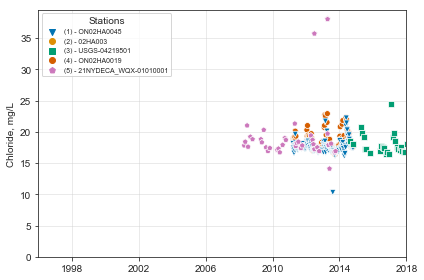

In [105]:
## fig,ax=plt.subplots(1,1,figsize=(6,4), dpi=100)

ax = sns.scatterplot(x='DATE', y='RESULT', data=TP, hue_order=selected_stations, hue='STATION', palette=pt, style='STATION', markers=["o", "v", "s", "p", "*", "o", "v", "s", "p", "*", "o", "v", "s", "p", "*"])
leg = ["({}) - {}".format(i+1,st) for i, st in enumerate(selected_stations)]

leg_handles = ax.get_legend_handles_labels()[0]
ax.legend(leg_handles[1:], leg, title='Stations', fontsize='x-small', loc='best')

# ax.legend(['(1) - HTLP (NCWQR)'], title='Stations', fontsize='x-small', loc=2)

plt.ylim(0,None)
plt.xlim(datetime.datetime(1996,1,1), datetime.datetime(2018,1,1))
plt.grid(alpha=0.5)
plt.ylabel("Chloride, mg/L")
plt.xlabel("")
plt.tight_layout()
plt.savefig('Rivers/'+river+'/'+river+'_Cl_meas.pdf')
plt.savefig('/Users/imarkelo/Google Drive/GDocuments/Lake Erie/Draft/Rivers_tables_chloride/img/Rivers/Canada/'+river+'/'+river+'_Cl_meas.pdf')



In [106]:
print(TP.groupby('STATION')["RESULT"].describe().reindex(selected_stations).round(2).to_latex())
      

\begin{tabular}{lrrrrrrrr}
\toprule
{} &  count &   mean &   std &   min &    25\% &    50\% &    75\% &   max \\
STATION               &        &        &       &       &        &        &        &       \\
\midrule
ON02HA0045            &  156.0 &  17.57 &  1.13 &  10.3 &  17.00 &  17.40 &  17.80 &  22.2 \\
02HA003               &    NaN &    NaN &   NaN &   NaN &    NaN &    NaN &    NaN &   NaN \\
USGS-04219501         &   38.0 &  17.80 &  1.54 &  16.4 &  16.70 &  17.35 &  18.08 &  24.4 \\
ON02HA0019            &  166.0 &  18.23 &  1.29 &  16.4 &  17.33 &  17.80 &  18.80 &  22.9 \\
21NYDECA\_WQX-01010001 &   40.0 &  19.95 &  5.86 &  14.1 &  17.40 &  18.05 &  19.05 &  38.1 \\
\bottomrule
\end{tabular}



In [107]:
selected_stations

['ON02HA0045',
 '02HA003',
 'USGS-04219501',
 'ON02HA0019',
 '21NYDECA_WQX-01010001']

In [108]:
master_stations = [st[0] for st in Show_IDS if st[1]]
# master_stations = selected_stations
master_st_df = TP[TP.STATION.isin(master_stations)]
master_st_df['USGSPCode'] = 0
master_st_df.shape

(400, 4)

In [109]:
master_st_df.DATE = master_st_df[master_st_df.DATE>datetime.datetime(1995,12,31)].DATE.dt.date
# = pd.to_date(master_st_df.DATE, format="%Y-%m-%d")
# master_st_df

In [110]:
master_st_df[[
    'DATE','USGSPCode', 'RESULT']].groupby('DATE').mean().reset_index().sort_values('DATE').to_csv(
    'Rivers/'+river+'/Cl_'+river+'iver_data.csv', index=False)

### Discharge

In [111]:
river

'Niagara_R'

In [112]:
sites = ['02HA003', ]
total_discharge = pd.DataFrame({})
for site in sites:
    discharge = WSC_FLOWS[WSC_FLOWS.index>datetime.datetime(1996,1,1)][site].to_frame()

    discharge = discharge.reset_index()
    discharge = discharge.rename(index=str, columns={site:'Discharge, cms', 'index':'Date'})
    discharge['Source'] = site
#     total_discharge[site] = discharge['Discharge, cms']
    discharge['Flow, CFS'] = discharge['Discharge, cms']/0.028
    total_discharge = pd.concat([total_discharge, discharge])

In [115]:
discharge = pd.read_excel('../../measurements/ECCC/Discharge_StClair_Detroit_Niagara_Sydenhame_Thames.xlsx')

In [117]:
discharge = discharge[['DATE', 'Niagara_R']]

In [118]:
discharge

,DATE,Niagara_R
0,1999-10-01,5607.36
1,1999-10-02,5210.88
2,1999-10-03,5040.96
3,1999-10-04,4701.12
4,1999-10-05,5182.56
5,1999-10-06,5239.20
6,1999-10-07,4984.32
7,1999-10-08,5239.20
8,1999-10-09,5267.52
9,1999-10-10,5182.56


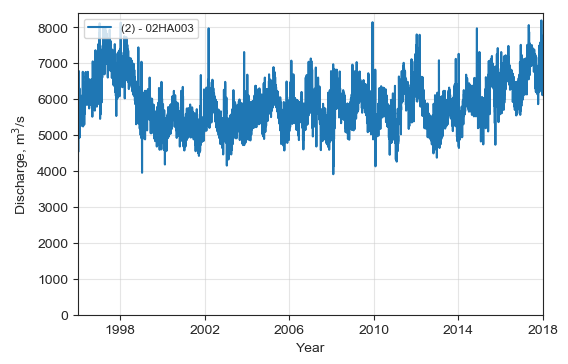

In [121]:
fig,ax=plt.subplots(1,1,figsize=(6,4), dpi=100)
ax=sns.lineplot(x='Date', y='Discharge, cms', data=total_discharge, hue='Source',ax=ax)

from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes

handles, lables = ax.get_legend_handles_labels()
ax.legend(['({}) - {}'.format(selected_stations.index(site)+1, site) for site in lables[1:]], loc=2, fontsize='small')

# ax=sns.lineplot(x='DATE', y='Niagara_R', data=discharge,ax=ax, label=)

ax.set_ylim(0,None)
ax.set_xlim(datetime.datetime(1996,1,1), datetime.datetime(2018,1,1))
ax.grid(alpha=0.5)
ax.set_ylabel("Discharge, m$^3$/s")
ax.set_xlabel("Year")

# axins = zoomed_inset_axes(ax, 8, loc='upper center')
# sns.lineplot(x='Date', y='Discharge, cms', data=discharge, hue='Source', ax=axins,zorder=10)
# axins.set_xlim(datetime.datetime(2010,4,1), datetime.datetime(2010,6,1)) # apply the x-limits
# axins.set_ylim(0, 10) # apply the y-limits
# plt.yticks(visible=False)
# plt.xticks(visible=False)
# from mpl_toolkits.axes_grid1.inset_locator import mark_inset
# mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")

plt.savefig('Rivers/'+river+'/'+river+'_Q.pdf')
plt.savefig('/Users/imarkelo/Google Drive/GDocuments/Lake Erie/Draft/Rivers_tables_chloride/img/Rivers/Canada/'+river+'/'+river+'_Q.pdf')

In [122]:
total_discharge.groupby(['Source']).describe()

Discharge, cms                                                   \
                 count         mean         std     min     25%     50%   
Source                                                                    
02HA003         8035.0  5876.080896  632.319415  3910.0  5415.0  5800.0   

                        Flow, CFS                                             \
            75%     max     count           mean          std            min   
Source                                                                         
02HA003  6270.0  8190.0    8035.0  209860.032003  22582.83625  139642.857143   

                                                                
                   25%            50%            75%       max  
Source                                                          
02HA003  193392.857143  207142.857143  223928.571429  292500.0

In [123]:
# discharge = total_discharge[total_discharge.Source=='02GG003']

In [124]:
# discharge['Flow, CFS'] = discharge['Flow, CFS']*1.5

In [125]:
total_discharge[['Date', 'Flow, CFS']].to_csv('Rivers/'+river+'/Flow_'+river+'_CFS.csv', index=False)


### Egret

In [126]:
river

'Niagara_R'

In [127]:

EGRET_Daily = pd.read_csv('Rivers/'+river+'/EGRET Result/Cl/'+river+'iver_Cl_Daily.csv')
EGRET_Sample = pd.read_csv('Rivers/'+river+'/EGRET Result/Cl/'+river+'iver_Cl_Sample.csv')


EGRET_Sample['Fx_Hat'] = EGRET_Sample['Q']*60*60*24*1000 * EGRET_Sample['ConcHat']/1000/1000
EGRET_Sample['Fx_C'] = EGRET_Sample['Q']*60*60*24*1000 * EGRET_Sample['ConcAve']/1000/1000


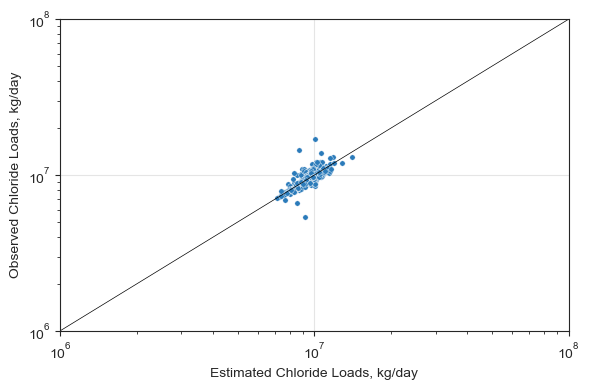

In [130]:
fig,ax=plt.subplots(1,1,figsize=(6,4), dpi=100)
sns.scatterplot(y='Fx_C', 
                x='Fx_Hat',
                data=EGRET_Sample,
                s=15,
                linewidth=0.3, ax=ax,
               color=sns.color_palette("Blues")[4])
# plt.legend("")
ax.set_xscale('log')
ax.set_yscale('log')
plt.plot([-100,100000000],[-100,100000000], 'k', lw=0.5)
min_lim, max_lim = 1e6, 1e8
plt.xlim(min_lim,max_lim)
plt.ylim(min_lim,max_lim)
# plt.xlim(datetime.datetime(1996,1,1), datetime.datetime(2018,1,1))
plt.grid(alpha=0.5)
plt.xlabel("Estimated Chloride Loads, kg/day")
plt.ylabel("Observed Chloride Loads, kg/day")
# plt.xlabel("")
plt.tight_layout()
plt.savefig('/Users/imarkelo/Google Drive/GDocuments/Lake Erie/Draft/Rivers_tables_chloride/img/Rivers/Canada/'+river+'/'+river+'_FvsF.pdf')


In [131]:
EGRET_Daily['FluxYearMTA'] = EGRET_Daily['FluxDay']*365/1000
EGRET_Daily['Fx_SE'] = (np.exp(EGRET_Daily['SE']+EGRET_Daily['yHat']) * EGRET_Daily['Q']*60*60*24*1000/1000/1000/1000-np.exp(EGRET_Daily['yHat']) * EGRET_Daily['Q']*60*60*24*1000/1000/1000/1000)*365
EGRET_Daily_an = EGRET_Daily.groupby('waterYear').mean().reset_index()


EGRET_Daily_an

,waterYear,Unnamed: 0,Q,Julian,Month,Day,DecYear,MonthSeq,i,LogQ,Q7,Q30,yHat,SE,ConcDay,FluxDay,FNConc,FNFlux,FluxYearMTA,Fx_SE
0,1996,137.0,6117.646468,53462.0,5.021978,138.000000,1996.376025,1757.021978,137.0,8.716301,6125.355062,6128.971120,2.886174,0.075019,17.989723,9.520668e+06,17.944138,9.288982e+06,3.475044e+06,269394.447539
1,1997,456.0,7000.218120,53781.0,6.526027,183.838356,1997.248374,1767.501370,456.0,8.851146,6996.303476,6985.557271,2.915480,0.070791,18.517715,1.118872e+07,18.262682,9.378808e+06,4.083882e+06,299640.058616
2,1998,821.0,6860.268618,54146.0,6.526027,183.838356,1998.248288,1779.501370,821.0,8.831847,6867.409181,6887.276756,2.910866,0.070885,18.429798,1.091465e+07,18.217133,9.356083e+06,3.983846e+06,292055.394250
3,1999,1186.0,5714.129022,54511.0,6.526027,183.838356,1999.248288,1791.501370,1186.0,8.648431,5721.186463,5751.775835,2.893287,0.070990,18.110031,8.942279e+06,18.173966,9.334581e+06,3.263932e+06,238757.350927
4,2000,1551.5,5427.588975,54876.5,6.513661,183.500000,2000.248889,1803.497268,1551.5,8.597166,5427.521870,5420.281342,2.887362,0.071106,18.002420,8.445722e+06,18.133034,9.313936e+06,3.082688e+06,225984.548668
5,2001,1917.0,5296.413977,55242.0,6.526027,183.838356,2001.248374,1815.501370,1917.0,8.573094,5300.300913,5317.311736,2.882927,0.071222,17.920110,8.201069e+06,18.095680,9.295722e+06,2.993390e+06,219971.102143
6,2002,2282.0,5630.453018,55607.0,6.526027,183.838356,2002.248288,1827.501370,2282.0,8.633125,5627.828742,5618.142671,2.887155,0.071348,17.992699,8.747905e+06,18.060948,9.278574e+06,3.192985e+06,236669.383973
7,2003,2647.0,5351.108160,55972.0,6.526027,183.838356,2003.248288,1839.501370,2647.0,8.582823,5348.697626,5345.595333,2.880378,0.071499,17.871756,8.265193e+06,18.029996,9.263371e+06,3.016795e+06,222720.742213
8,2004,3012.5,5676.135065,56337.5,6.513661,183.500000,2004.248889,1851.497268,3012.5,8.641686,5675.408749,5664.503090,2.884374,0.071653,17.941340,8.798919e+06,18.002879,9.249821e+06,3.211605e+06,238400.233730
9,2005,3378.0,5883.891564,56703.0,6.526027,183.838356,2005.248374,1863.501370,3378.0,8.677673,5884.026142,5896.813318,2.885867,0.071820,17.967685,9.136740e+06,17.981363,9.239801e+06,3.334910e+06,248826.507927


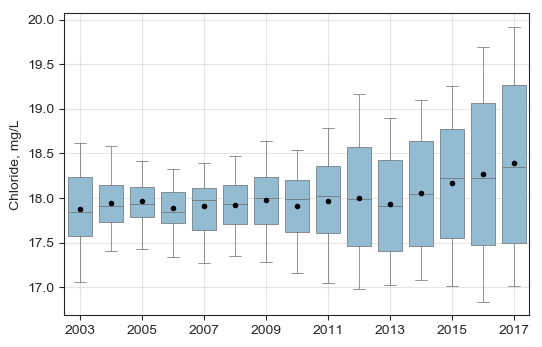

In [137]:
fig,ax=plt.subplots(1,1,figsize=(6,4), dpi=100)

# sns.boxplot(EGRET_Daily['waterYear'], EGRET_Daily['ConcDay'], color=sns.color_palette()[0])

# plt.fill_between(EGRET_Daily_an['waterYear'][5:-1],
#                  np.exp(EGRET_Daily_an['yHat'][5:-1]-EGRET_Daily_an['SE'][5:-1]),
#                  np.exp(EGRET_Daily_an['yHat'][5:-1]+EGRET_Daily_an['SE'][5:-1]), 
#                  color=sns.color_palette()[0], alpha=0.15)
# plt.plot(EGRET_Daily_an['waterYear'][5:-1], EGRET_Daily_an['FluxYearMTA'][5:-1])

# sns.scatterplot(x="waterYear", y="FluxYearMTA",
#                 sizes=(1, 8), linewidth=0.3,
#                 data=EGRET_Daily_an, ax=ax)

meanpointprops = dict(marker='.', markeredgecolor='black', markersize=6,markerfacecolor='black')
ax = sns.boxplot(showmeans=True, linewidth=0.5, meanprops=meanpointprops, x="waterYear", y="ConcDay", 
                 data=EGRET_Daily, showfliers=False, color=sns.color_palette("Blues")[2],
                order=range(2003,2018))

# ax = sns.boxplot(showmeans=True, linewidth=0.5, meanprops=meanpointprops, x="waterYear", y="ConcDay", data=EGRET_Daily, showfliers=False, color=sns.color_palette("Blues")[2])
# ax.set_yscale('log')
# plt.legend("")
# plt.plot([-100,100],[-100,100], 'k', lw=0.5)
# plt.xlim(2003,2018)
plt.xlim(-0.5, 14.5)
locs, labels = plt.xticks() 
plt.xticks(locs[::2], labels[::2])
# plt.ylim(0,None)
# plt.vlines(4.5, 0, 0.6, 'k', '-.', lw=0.7)
# plt.vlines(9.5, 0, 0.6, 'k', '-.', lw=0.7)

# ax.set_xticks([int(x) for x in np.linspace(2003,2017, 8)])

plt.grid(alpha=0.5)
plt.ylabel("Chloride, mg/L")
plt.xlabel("")
# fig.autofmt_xdate()
# plt.savefig('One_by_one/Western/US/Portage R/Portage Q.pdf')
plt.savefig('/Users/imarkelo/Google Drive/GDocuments/Lake Erie/Draft/Rivers_tables_chloride/img/Rivers/Canada/'+river+'/'+river+'_Cl.pdf')



In [133]:
EGRET_Daily_an['Fx_AE'] = (abs(EGRET_Sample['Fx_Hat'] - EGRET_Sample['Fx_C'])/EGRET_Sample['Fx_C']).mean()*EGRET_Daily_an['FluxYearMTA']




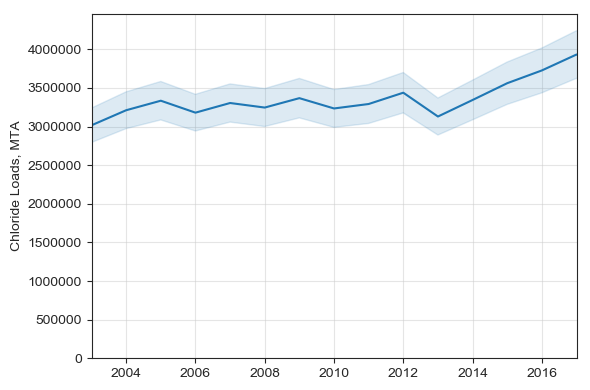

In [138]:
fig,ax=plt.subplots(1,1,figsize=(6,4), dpi=100)

k=None
plt.plot(EGRET_Daily_an['waterYear'][:k], EGRET_Daily_an['FluxYearMTA'][:k], c=sns.color_palette()[0])

# s=12
# plt.plot(EGRET_Daily_an['waterYear'][s:], EGRET_Daily_an['FluxYearMTA'][s:], c=sns.color_palette()[0])

plt.fill_between(EGRET_Daily_an['waterYear'][:k],
                 EGRET_Daily_an['FluxYearMTA'][:k]-EGRET_Daily_an['Fx_SE'][:k],
                 EGRET_Daily_an['FluxYearMTA'][:k]+EGRET_Daily_an['Fx_SE'][:k], 
                 color=sns.color_palette()[0], alpha=0.15)

# plt.fill_between(EGRET_Daily_an['waterYear'][s:],
#                  EGRET_Daily_an['FluxYearMTA'][s:]-EGRET_Daily_an['Fx_SE'][s:],
#                  EGRET_Daily_an['FluxYearMTA'][s:]+EGRET_Daily_an['Fx_SE'][s:], 
#                  color=sns.color_palette()[0], alpha=0.15)



# plt.vlines(2007, 0, 200, 'k', '-.', lw=0.7)
# plt.vlines(2013, 0, 200, 'k', '-.', lw=0.7)


# plt.plot(EGRET_Daily_an['waterYear'][5:-1], EGRET_Daily_an['FluxYearMTA'][5:-1])

# sns.scatterplot(x="waterYear", y="FluxYearMTA",
#                 sizes=(1, 8), linewidth=0.3,
#                 data=EGRET_Daily_an, ax=ax)

# meanpointprops = dict(marker='D', markeredgecolor='black', markersize=1,markerfacecolor=sns.color_palette()[3])
# ax = sns.boxplot(linewidth=0.5, meanprops=meanpointprops, x="waterYear", y="FluxYearMTA", data=EGRET_Daily, showfliers=False, color=sns.color_palette("Blues")[2])
# ax.set_yscale('log')
# plt.legend("")
# plt.plot([-100,100],[-100,100], 'k', lw=0.5)
plt.ylim(0,None)
plt.xlim(2003,2017)
# plt.xticks([int(x) for x in np.linspace(5,19,8)], [int(x) for x in np.linspace(2003,2017, 8)])
# plt.ylim(0,200)
# plt.xlim(datetime.datetime(1996,1,1), datetime.datetime(2018,1,1))
plt.grid(alpha=0.5)
plt.ylabel("Chloride Loads, MTA")
plt.xlabel("")
plt.tight_layout()
# plt.savefig('One_by_one/Western/US/Portage R/Portage Q.pdf')
plt.savefig('/Users/imarkelo/Google Drive/GDocuments/Lake Erie/Draft/Rivers_tables_chloride/img/Rivers/Canada/'+river+'/'+river+'_Cl_Flux.pdf')


In [135]:
print(EGRET_Daily_an[(EGRET_Daily_an.waterYear<2018) & (EGRET_Daily_an.waterYear>2002)][['waterYear', 'FluxYearMTA','Fx_SE']].round(1).T.to_latex(index=False))

\begin{tabular}{rrrrrrrrrrrrrrr}
\toprule
        7  &         8  &         9  &         10 &         11 &         12 &         13 &         14 &         15 &         16 &         17 &         18 &         19 &         20 &         21 \\
\midrule
    2003.0 &     2004.0 &     2005.0 &     2006.0 &     2007.0 &     2008.0 &     2009.0 &     2010.0 &     2011.0 &     2012.0 &     2013.0 &     2014.0 &     2015.0 &     2016.0 &     2017.0 \\
 3016795.5 &  3211605.3 &  3334910.0 &  3180173.2 &  3305146.1 &  3246239.1 &  3367964.1 &  3234532.6 &  3292127.2 &  3438550.9 &  3130196.9 &  3344106.9 &  3561542.2 &  3726794.9 &  3932769.2 \\
  222720.7 &   238400.2 &   248826.5 &   237490.6 &   247109.2 &   245616.3 &   255388.5 &   244930.5 &   251758.2 &   261562.3 &   239757.2 &   256914.3 &   274347.2 &   290267.4 &   308147.6 \\
\bottomrule
\end{tabular}



In [136]:
print(TP.groupby('STATION')["RESULT"].describe().reindex(selected_stations).round(2).to_latex())
   

\begin{tabular}{lrrrrrrrr}
\toprule
{} &  count &   mean &   std &   min &    25\% &    50\% &    75\% &   max \\
STATION               &        &        &       &       &        &        &        &       \\
\midrule
ON02HA0045            &  156.0 &  17.57 &  1.13 &  10.3 &  17.00 &  17.40 &  17.80 &  22.2 \\
02HA003               &    NaN &    NaN &   NaN &   NaN &    NaN &    NaN &    NaN &   NaN \\
USGS-04219501         &   38.0 &  17.80 &  1.54 &  16.4 &  16.70 &  17.35 &  18.08 &  24.4 \\
ON02HA0019            &  166.0 &  18.23 &  1.29 &  16.4 &  17.33 &  17.80 &  18.80 &  22.9 \\
21NYDECA\_WQX-01010001 &   40.0 &  19.95 &  5.86 &  14.1 &  17.40 &  18.05 &  19.05 &  38.1 \\
\bottomrule
\end{tabular}

